# **COGS 108 Final Project**

## **Overview**

In this data analysis, I attempted to answer the question of whether or not there exists a correlation between a restaurant's Yelp score and the rating it receives from a health inspector, relative to the socioeconomic status of its location. This was motivated by a desire to utilise the immense amount of user provided data on social media sources to improve the health inpsection process in terms of representation and efficiency. To do this, I utilised datasets containing information on Yelp reviews,health inspections, and economic data by zip code, which were cleaned and merged for ease of analysis. Upon completing the analysis (detailed below), I found that there is no statistically significant evidence that race or income biases the score a resaturant receives from either the health inspector or Yelp critics.

## **Name and Github**

* Name: Josh Miller (A13304520)
* Github username: jmillergit

## **Research Question**

Does the socioeconomic status of a restaurant's location effect the relative scores it receives from health inspectors or Yelp critics?

## **Background and Prior Work**

Health inspectors complete inspections of restaurants in which they analyze every facet of health and safety a restaurant provides to its empoyees and customers. However in the age of data and social media, what if we could integrate the two in order to improve the antiquated process of assigning inspectors, while also improving representation for neglected communities?

According to source 1, the restaurant health inspection process is run in such a manner as to place higher importance on restaurants with waring factors such as the type of food served or its compliance history. For example a sushi restaurant (raw preparation) which had violations on its previous check in would have higher priority than a restaurant that has scored perfectly in the past. This however seems like a clumsy way of assigning the limited staff of health inspectors.

We see an example of prior data science work in source 2, that utilised social media posts about restaurants in Boston to improve the health inspection process. This would serve to add a more modern (and frequently updated) base of knowledge on a large number of restaurants in a given city. Additionally, all data is user submitted so health inspectors would not need to look up prior offenses and other antiquated methods such as those listed in source 1.

References (include links):

1)https://recipes.howstuffworks.com/tools-and-techniques/restaurant-health-inspections.htm

2)https://www.drivendata.org/competitions/5/keeping-it-fresh-predict-restaurant-inspections/


## **Hypothesis**

I believe that there will be evidence of lower health inspector reviews in lower ranked socioeconomic areas due to preexisting bias and prejudice that may be held by said inspectors. Conversely, I believe Yelp reviews will be more evenly distributed due to the consumers desire to share their honest opinion to friends and society at large. 

## **Data Sets**

* Dataset Name: inspections.csv
* Link to the dataset: https://canvas.ucsd.edu/courses/12630/files?
* Number of observations:18,466
* Description: This dataset contains a varitety of information pertaining to restaraunt health inspections including names, scores, inspector id's, etc.


* Dataset Name: yelp.csv
* Link to the dataset: https://canvas.ucsd.edu/courses/12630/files?
* Number of observations:3,688
* Description: This dataset includes information regarding the Yelp scores of restaurants in South Carolina including score, type of cuisine, location, etc.


* Dataset Name: zipcodes.csv
* Link to the dataset: https://canvas.ucsd.edu/courses/12630/files?
* Number of observations:38
* Description:This relatively small dataset includes economic and social statistics for a number of zipcodes in South Carolina i.e mean household income, percent non-white, etc.



I plan to combine the inspections and yelp datasets by inner merging on the phone number parameter in order to lower the number of repeated entries or similar events. Then to merge this new dataset with the zipcodes data by using another inner merge on zipcode this time since it is a shared variable amongst the two.

## **Setup**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import numpy as np
from scipy.stats import spearmanr

insp_df = pd.read_csv('inspections.csv')
yelp_df = pd.read_csv('yelp.csv')
econ_df = pd.read_csv('zipcodes.csv')

## **Data Cleaning**

In [2]:
#health inspection dataset cleaning
insp_df = insp_df[['name','city','state','zip','phonenumber','score','inspector_id']] #drop unneccesary columns
insp_df = insp_df.sort_values(by=['zip']) #sort entries by zipcode
insp_df = insp_df.rename(columns = {'phonenumber':'phone'}) #tidy up column names
insp_df = insp_df.drop_duplicates(subset='name', keep="last") #remove duplicated inspections
insp_df = insp_df.dropna() #remove any null entries

#method to standardize phone number column (in order to merge with yelp_df later)
def clean_number(string):
    string = str(string)
    string = "1" + string
    string = string.replace('(','')
    string = string.replace(')','')
    string = string.replace('-','')
    string = string.replace(' ','')
    string = string.strip()
    return string

insp_df['phone'] = insp_df['phone'].apply(clean_number) #apply function to relevant row

In [3]:
#yelp review dataset cleaning
yelp_df = yelp_df[['name','rating','address1','zip_code','phone']] #eliminate irrelevant columns
yelp_df = yelp_df.rename(columns ={'rating':'score','address1':'address','zip_code':'zip'}) #tidy up column names
yelp_df = yelp_df.dropna() #drop any null entries

In [4]:
#zip code economic dataset cleaning
econ_df = econ_df[['zip', 'median_family_income_dollars','percent_damilies_below_poverty_line','percent_nonwhite']]
econ_df = econ_df.rename(columns = {'zip':"Zip", 'median_family_income_dollars':'Income($)',
                                    'percent_damilies_below_poverty_line':'Poverty_Pcnt',
                                    'percent_nonwhite':'Nonwhite_Pcnt'})

In [5]:
#merge into final restaurants data set with all relevant info
restaurants_df = pd.merge(left=insp_df, right=yelp_df, left_on='phone', right_on='phone') #merge on shared phone #'s
restaurants_df = restaurants_df[['name_y','city','state','zip_y','score_x','inspector_id','score_y']] #choose columns
restaurants_df = restaurants_df.rename(columns = {'name_y':'Name','city':'City','state':'State',#rename columns
                                                  'score_x':"Inspector_Score",'inspector_id':'Inspector',
                                                  'score_y':'Yelp_Score','zip_y':'Zip'})
restaurants_df = pd.merge(left=restaurants_df, right=econ_df, left_on='Zip', right_on='Zip') #final merge on zip
restaurants_df #display final cleaned df

,Name,City,State,Zip,Inspector_Score,Inspector,Yelp_Score,Income($),Poverty_Pcnt,Nonwhite_Pcnt
0,bitter melon asian market,angier,NC,27501,94.0,1.0,5.0,59408,10.5,17.9
1,chipotle mexican grill,apex,NC,27502,99.0,10.0,3.0,109891,3.4,18.9
2,pizza hut,apex,NC,27502,97.0,22.0,3.0,109891,3.4,18.9
3,j & s new york pizza,apex,NC,27502,99.0,22.0,4.0,109891,3.4,18.9
4,starbucks,apex,NC,27502,97.0,1.0,2.5,109891,3.4,18.9
...,...,...,...,...,...,...,...,...,...,...
1849,dunkin' donuts,raleigh,NC,27614,95.5,7.0,2.0,119232,3.7,16.6
1850,mizu,raleigh,NC,27614,95.0,7.0,4.0,119232,3.7,16.6
1851,bruegger's bagels,raleigh,NC,27614,93.5,9.0,4.0,119232,3.7,16.6
1852,mcdonald's,raleigh,NC,27614,95.5,9.0,1.0,119232,3.7,16.6


## **Data Visualization**

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Score')

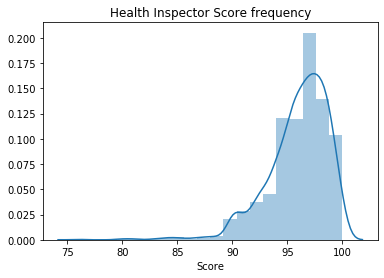

In [6]:
bar1 = sns.distplot(restaurants_df['Inspector_Score'],bins = 20)
bar1.set_title('Health Inspector Score frequency')
bar1.set_xlabel('Score')

**Interpretation:**We can see that the distribution of health inspector scores is skewed to the left, with a majority of the scores being above the 90 mark. However, there are a number of scores between 75 and 90 that should be looked at once we delve further into the analysis. These could proove vital when we see where these restaurants were located.

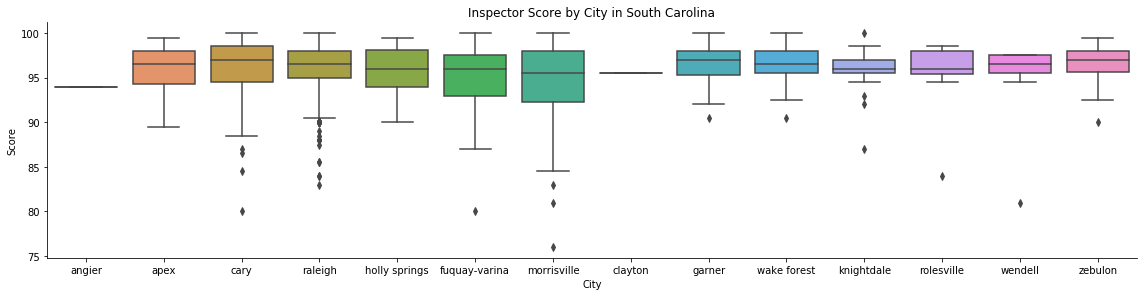

In [7]:
box1 = sns.catplot(x = "City", y = "Inspector_Score",  kind = 'box', height = 4, aspect = 4, data = restaurants_df)
plt.title('Inspector Score by City in South Carolina')
box1.set(ylabel = 'Score')

**Interpretation:** We can see extremely high mean scores across the list of cities included (~95), however it is now more evident that the majority of the lower scores are clustered around a selection of cities such as Cary, Raleigh, Morisville, and others which could be relevant to the research question.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


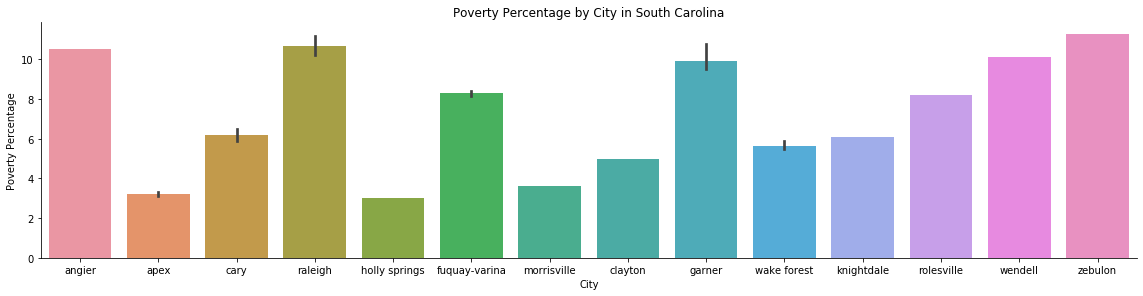

In [8]:
box2 = sns.catplot(x = "City", y = "Poverty_Pcnt", kind = 'bar',height = 4, aspect = 4, data = restaurants_df)
plt.title('Poverty Percentage by City in South Carolina')
box2.set(ylabel = 'Poverty Percentage')

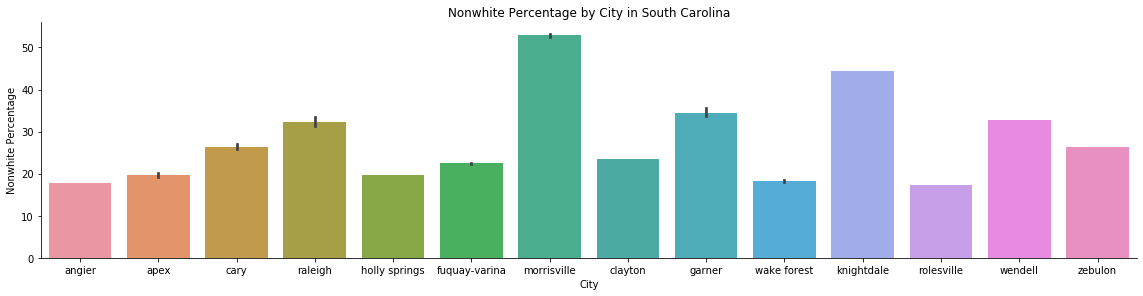

In [9]:
box2 = sns.catplot(x = "City", y = "Nonwhite_Pcnt", kind = 'bar',height = 4, aspect = 4, data = restaurants_df)
plt.title('Nonwhite Percentage by City in South Carolina')
box2.set(ylabel = 'Nonwhite Percentage')

**Interpretation:** Upon further investigation of the cities that grabbed our attention in the prior graph, we can see from the two plots above, that there doesn't actually appear to be a correlation between the Poverty or Nonwhite percentage of a city and the inspector scores it received, which would go against our hypothesis. The one clear exception to this is the city of Morrisville which has the highest recorded nonwhite percentage and some of the lowest Inspector scores. We can confirm and analyze this trend and outlier with statistic tests laster.

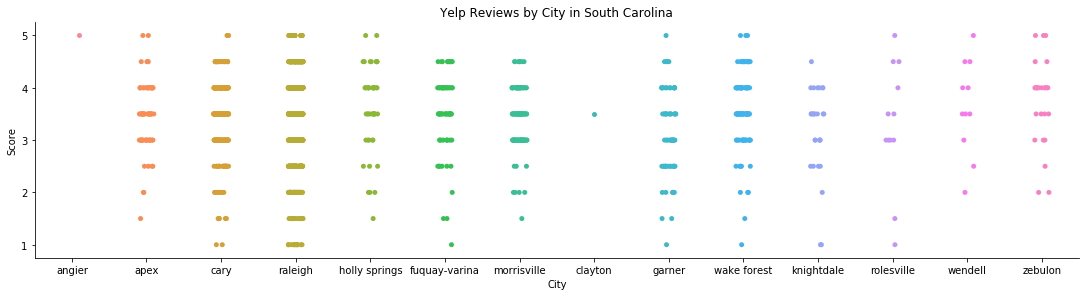

In [10]:
box3 = sns.catplot(x = "City", y = "Yelp_Score", height = 4, aspect = 3.8, data = restaurants_df)
plt.title('Yelp Reviews by City in South Carolina')
box3.set(ylabel = 'Score')

**Interpretation:**As predicted, Yelp scores seem to be much more evenly distributed in all cities compared to the health inspector grades. There are some cities with lacking data (Angier and Dayton) which could skew data, however no conclusions will be drawn until we perform statistical tests for correlation.

## **Data Analysis and Results**

**Background:**Because the variables in question (inspector score, poverty percent, and yelp score) are not normally distributed we cannot use the pearson correlation test as it would be breaking one of the primary assumptions. Therefore we must use statistical test for non parametric data, namely the Spearman's test. This test compares the rank values of the data and allows us to see if there exists a correlation between our variables depite the lack of a Gaussian distribution.

In [11]:
coefficient, pval = spearmanr(restaurants_df['Poverty_Pcnt'],restaurants_df['Inspector_Score'])
print ('Poverty Percentage-Inspector score coefficient:',coefficient)
print ('Poverty Percentage-Inspector score P-value:',pval)
print('\n')

coefficient2, pval2 = spearmanr(restaurants_df['Poverty_Pcnt'],restaurants_df['Yelp_Score'])
print ('Poverty Percentage-Yelp score coefficient:',coefficient2)
print ('Poverty Percentage-Yelp score P-value:',pval2)
print('\n')

coefficient3, pval3 = spearmanr(restaurants_df['Nonwhite_Pcnt'],restaurants_df['Inspector_Score'])
print ('Nonwhite Percentage-Inspector score coefficient:',coefficient3)
print ('Nonwhite Percentage-Inspector score P-value:',pval3)
print('\n')

coefficient4, pval4 = spearmanr(restaurants_df['Nonwhite_Pcnt'],restaurants_df['Yelp_Score'])
print ('Nonwhite Percentage-Yelp score coefficient:',coefficient4)
print ('Nonwhite Percentage-Yelp score P-value:',pval4)
print('\n')

coefficient5, pval5 = spearmanr(restaurants_df['Income($)'],restaurants_df['Inspector_Score'])
print ('Mean Income-Inspector score coefficient:',coefficient5)
print ('Mean Income-Inspector score P-value:',pval5)
print('\n')

coefficient6, pval6 = spearmanr(restaurants_df['Income($)'],restaurants_df['Yelp_Score'])
print ('Mean Income-Yelp score coefficient:',coefficient6)
print ('Mean Income-Yelp score P-value:',pval6)

Poverty Percentage-Inspector score coefficient: 0.030245926185622666
Poverty Percentage-Inspector score P-value: 0.19300131283952923


Poverty Percentage-Yelp score coefficient: -0.004322700884298324
Poverty Percentage-Yelp score P-value: 0.8524427005875267


Nonwhite Percentage-Inspector score coefficient: -0.06074036615927346
Nonwhite Percentage-Inspector score P-value: 0.008896226050230075


Nonwhite Percentage-Yelp score coefficient: -0.07509626619234572
Nonwhite Percentage-Yelp score P-value: 0.0012126338580471325


Mean Income-Inspector score coefficient: 0.015083785186304793
Mean Income-Inspector score P-value: 0.5162879399707168


Mean Income-Yelp score coefficient: 0.02372928697424425
Mean Income-Yelp score P-value: 0.30716314386308835


 **Analysis:** We can see that the coefficients for poverty percent relative to inspector score and yelp review are 0.003 and -0.004 respectively. The coefficients for nonwhite percent relative to inspector score and yelp review are -0.06 and -0.07 respectively.And the coefficients for mean income relative to inspector score and yelp review are 0.01 and 0.02 respectively. This fact, along with the extremely high p-values associated with the poverty and mean income coefficients seems to indicate that there is in fact no correlation between the poverty percentage, nonwhite percentage, or mean income of a community and the reviews it receives from either health inspectors or normal clients.

## **Ethics and Privacy**

I do not see any privacy concerns regarding the data that I have mentioned up to this point. Specifically, Yelp is a public application for users to post reviews of restaurants so I do not believe it would be innappropriate to use the work of those individuals reviewing restaurants. Additionally, health inspection scores are legally required to be posted for consumers to be aware of the cleanliness of any restaurant they can go to, so again there is no privacy concern in my mind.

One potential issue I could forsee is the lack of representation of poorer individuals and the restaurants they frequent due to the fact that 1)they might not have access or interest in posting Yelp reviews and 2) the restaurants may be family owned/local and might not haqve yelp data. to address these issues I would have to analyze correlations between NaN data found for yelp reviews which I'm sure will be quite a lot. In this case, to use this data we could use the restaurants past health inspector scores to prioritize them since no Yelp data would be available.

## **Conclusion and Discussion**

After the process of cleaning, merging, plotting, and analyzing the data provided it appears that I failed to reject the null hypothesis. In other words, there does not seem to be evidence of racial or economic bias in either the health inspector grading system or Yelp critic reviews. The results showed a distinctly low correlation between any of the noted variables after completing a Spearman's coefficient calculation on the non-gaussian data. This would seem to show that the lower inspector scores which were noticed upon preliminary viewing of the data and plots is a fair representation of the status of the establishment's function, and the wide variety of Yelp reviews is most likely explained by the various degrees of standard and scrutiny of Yelp reviewers. 